## Case Study, Part 2 - Modelling Lifetime Post Consumers <br>

### Investigation Structure
1. Question Statement
2. Data Dictionary
3. Dataset
4. Exploratory Data Analysis
5. Pre-processing
6. Modeling
7. Model Evaluation
8. Conclusion
9. Improve / Productionise

Data comes via the UCI dataset: https://archive.ics.uci.edu/ml/datasets/Facebook+metrics

#### 1. Question Statement
Predict ‘Lifetime post consumers’ using any or all of the following features: <br>
Category <br>Type  <br>Page total likes <br>Post Month <br>Post Weekday <br>Post Hour <br>Paid

In [1]:
import os
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from scipy import stats
from scipy.special import boxcox, inv_boxcox
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_squared_error

#### 2. Data dictionary

##### Categories 
- 1 = action
- 2 = product
- 3 = inspiration

##### Paid 
- 1 = paid 
- 0 = not paid

I will refer to `Lifetime Post Consumers` as **LPC** in short

#### 3. Dataset

In [2]:
fb_data = pd.read_csv("dataset_Facebook.csv",sep=';')

In [3]:
fb_data = fb_data[['Category', 'Type', 'Page total likes', 'Post Month', 'Post Weekday', 'Post Hour', 'Paid', 'Lifetime Post Consumers']]

#### 4. Exploratory Data Analysis

In [4]:
fb_data.head()

,Category,Type,Page total likes,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Consumers
0,2,Photo,139441,12,4,3,0.0,109
1,2,Status,139441,12,3,10,0.0,1361
2,3,Photo,139441,12,3,3,0.0,113
3,2,Photo,139441,12,2,10,1.0,790
4,2,Photo,139441,12,2,3,0.0,410


##### Use pandas profiling to take a look at correlations and univariate statistics

In [5]:
if not os.path.isfile("profile_output.html"):
    profile = ProfileReport(fb_data, title='Pandas Profiling Report', html={'style':{'full_width':True}})
    profile.to_file(output_file="profile_output.html")

##### Open profile html file

In [6]:
!open profile_output.html

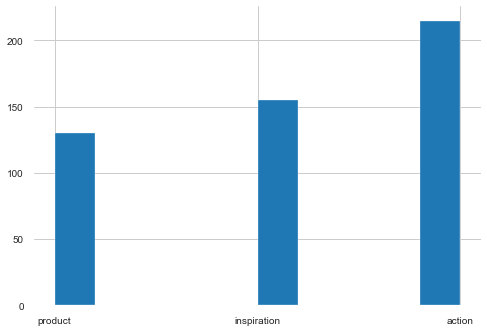

In [7]:
fb_data.Category = fb_data.Category.map({1:'action',2:'product',3:'inspiration'})
fb_data.Category.hist()
plt.show()

(0.0, 3000.0)

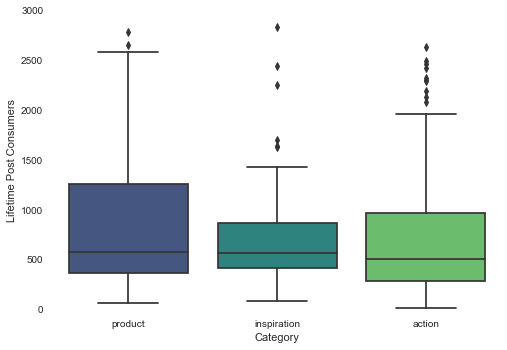

In [8]:
sns.boxplot(x='Category',y='Lifetime Post Consumers',data=fb_data[fb_data['Lifetime Post Consumers']<8000],palette='viridis')
plt.ylim(0,3000)

- Most post were of Category 1[Action].
- Even though action category is the most common, it doesn't have the highest Lifetime post consumer(LPC). Product and Inspiration on average have the same LPC, action category has the lowest LPC.

#### 5. Preprocessing

In [9]:
fb_data.columns

Index(['Category', 'Type', 'Page total likes', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid', 'Lifetime Post Consumers'],
      dtype='object')

##### Missing values
From our EDA profiling, we know that only Paid feature has a missing values.

In [10]:
# number of missing values per feature
fb_data.isna().sum()

Category                   0
Type                       0
Page total likes           0
Post Month                 0
Post Weekday               0
Post Hour                  0
Paid                       1
Lifetime Post Consumers    0
dtype: int64

In [11]:
# how many missing values
fb_data.Paid.value_counts(dropna=False)

0.0    360
1.0    139
NaN      1
Name: Paid, dtype: int64

In [12]:
fb_data[fb_data.Paid.isna()]

,Category,Type,Page total likes,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Consumers
499,product,Photo,81370,1,4,4,NaN,524


In [13]:
fb_data.groupby('Paid')['Lifetime Post Consumers'].median()

Paid
0.0    544.5
1.0    575.0
Name: Lifetime Post Consumers, dtype: float64

We will replace the missing Paid value with 0(unpaid) because its the most common and the LPC value is closest to mean/median of the unpaid group

In [14]:
# Treatment
fb_data.Paid.fillna(0, inplace=True)

##### Outliers 
Looking at the distribution for LPC in the data profile, we can clearly see that there is an anomaly around.

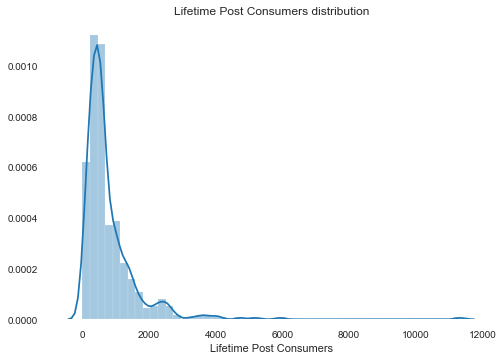

In [15]:
sns.distplot(fb_data['Lifetime Post Consumers'])
plt.title('Lifetime Post Consumers distribution')
plt.show()

In [16]:
lpc_outlier_cutoff = np.percentile(fb_data['Lifetime Post Consumers'],90)
print(f'The outlier cutoff value using the 90th percentile is {int(lpc_outlier_cutoff)}')

The outlier cutoff value using the 90th percentile is 1601


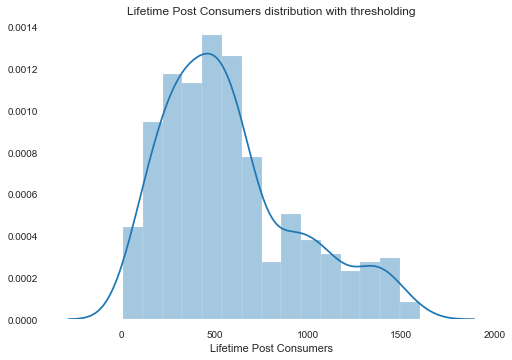

In [17]:
sns.distplot(fb_data[fb_data['Lifetime Post Consumers']<lpc_outlier_cutoff]['Lifetime Post Consumers'])
plt.title('Lifetime Post Consumers distribution with thresholding')
plt.show()

In [18]:
print(f'Data shape before outlier cutoff {fb_data.shape}')
fb_data = fb_data[fb_data['Lifetime Post Consumers']<lpc_outlier_cutoff]
print(f'Data shape after outlier cutoff {fb_data.shape}')

Data shape before outlier cutoff (500, 8)
Data shape after outlier cutoff (450, 8)


##### Normalising skewed features

In [19]:
fb_data.skew()

Page total likes          -0.995776
Post Month                -0.111457
Post Weekday              -0.069516
Post Hour                  0.255260
Paid                       1.045982
Lifetime Post Consumers    0.840771
dtype: float64

QQ plots
- Lifetime Post Consumers [LPC]
- Page total likes

Lifetime Post Consumers

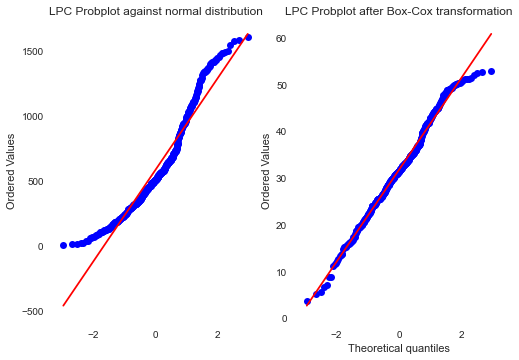

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
prob = stats.probplot(fb_data['Lifetime Post Consumers'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('LPC Probplot against normal distribution')

ax2 = fig.add_subplot(122)
_,lpc_lambda = stats.boxcox(fb_data['Lifetime Post Consumers'])
lpc_norm = boxcox(fb_data['Lifetime Post Consumers'],lpc_lambda)
prob = stats.probplot(lpc_norm, dist=stats.norm, plot=ax2)
ax2.set_title('LPC Probplot after Box-Cox transformation')

plt.show()

Page total likes

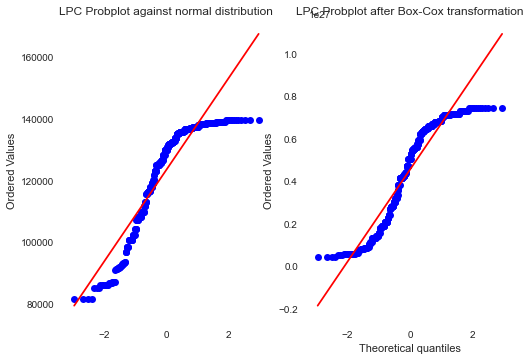

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
prob = stats.probplot(fb_data['Page total likes'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('LPC Probplot against normal distribution')

ax2 = fig.add_subplot(122)
_, ptl_lambda = stats.boxcox(fb_data['Page total likes'])
ptl_norm = boxcox(fb_data['Page total likes'],ptl_lambda)
prob = stats.probplot(ptl_norm, dist=stats.norm, plot=ax2)
ax2.set_title('LPC Probplot after Box-Cox transformation')

plt.show()

Applying the boxcox transformations improves the distribution of LPC but not that of the Page Total Likes. So we will transform the target variable only. 

In [22]:
fb_data['lpc_norm_trans'] = boxcox(fb_data['Lifetime Post Consumers'],lpc_lambda)

##### Feature Scaling
- page total likes

In [23]:
fb_data.describe()

,Page total likes,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Consumers,lpc_norm_trans
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,123342.308889,7.051111,4.097778,7.808889,0.268889,582.728889,31.693048
std,16044.519358,3.283157,2.035157,4.414888,0.443876,362.432935,9.826155
min,81370.000000,1.000000,1.000000,1.000000,0.000000,9.000000,3.652805
25%,113028.000000,4.000000,2.000000,3.000000,0.000000,319.000000,25.336696
50%,129600.000000,7.000000,4.000000,9.000000,0.000000,507.500000,31.437730
75%,136393.000000,10.000000,6.000000,11.000000,1.000000,741.500000,37.405542
max,139441.000000,12.000000,7.000000,23.000000,1.000000,1599.000000,52.930746


Because this is a regression problem when using models which optimise distance such as linear regression we need to try and ensure that all features are on similar scales. 
I chose the min_max scaler instead of standardisation because even though the 'page total likes' is a countinous feature, there seems to be clear groupings.

In [24]:
min_max_scaler = MinMaxScaler()

In [25]:
fb_data['Page_total_likes_minmax'] = min_max_scaler.fit_transform(fb_data[['Page total likes']].values)

##### Categories to numerics

In [26]:
onehot = OneHotEncoder(dtype=np.int, sparse=False,handle_unknown='error')

In [27]:
cat_df = fb_data[['Category','Type','Post Month','Post Weekday','Post Hour','Paid']].astype(object)
categorical_array = onehot.fit_transform(cat_df)

In [28]:
ohe_feats = onehot.get_feature_names()
ohe_feats

array(['x0_action', 'x0_inspiration', 'x0_product', 'x1_Link', 'x1_Photo',
       'x1_Status', 'x1_Video', 'x2_1', 'x2_2', 'x2_3', 'x2_4', 'x2_5',
       'x2_6', 'x2_7', 'x2_8', 'x2_9', 'x2_10', 'x2_11', 'x2_12', 'x3_1',
       'x3_2', 'x3_3', 'x3_4', 'x3_5', 'x3_6', 'x3_7', 'x4_1', 'x4_2',
       'x4_3', 'x4_4', 'x4_5', 'x4_6', 'x4_7', 'x4_8', 'x4_9', 'x4_10',
       'x4_11', 'x4_12', 'x4_13', 'x4_14', 'x4_15', 'x4_16', 'x4_17',
       'x4_18', 'x4_19', 'x4_20', 'x4_22', 'x4_23', 'x5_0.0', 'x5_1.0'],
      dtype=object)

In [29]:
ohe_prefix = [f'x{i}' for i in range(cat_df.shape[1])]
onehot_column_mappings = dict(zip(ohe_prefix,cat_df.columns.to_list()))
onehot_column_mappings

{'x0': 'Category',
 'x1': 'Type',
 'x2': 'Post Month',
 'x3': 'Post Weekday',
 'x4': 'Post Hour',
 'x5': 'Paid'}

In [30]:
ohe_feats_names = [] 
for name in ohe_feats:
    prefix = name.split('_')[0]
    if prefix in onehot_column_mappings:
        ohe_feats_names.append(name.replace(prefix,onehot_column_mappings[prefix]))

In [31]:
categorical_df = pd.DataFrame(categorical_array,columns=ohe_feats_names)
categorical_df.head()

,Category_action,Category_inspiration,Category_product,Type_Link,Type_Photo,Type_Status,Type_Video,Post Month_1,Post Month_2,Post Month_3,...,Post Hour_15,Post Hour_16,Post Hour_17,Post Hour_18,Post Hour_19,Post Hour_20,Post Hour_22,Post Hour_23,Paid_0.0,Paid_1.0
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [32]:
cat_df.shape

(450, 6)

In [33]:
categorical_df.shape

(450, 50)

In [34]:
X = categorical_df
X['Page_total_likes_minmax'] = fb_data.Page_total_likes_minmax.values
X['lpc_norm_trans'] = fb_data.lpc_norm_trans.values

In [35]:
X.shape

(450, 52)

#### 6. Modelling

In [36]:
y = X.pop('lpc_norm_trans')

In [37]:
X.head()

,Category_action,Category_inspiration,Category_product,Type_Link,Type_Photo,Type_Status,Type_Video,Post Month_1,Post Month_2,Post Month_3,...,Post Hour_16,Post Hour_17,Post Hour_18,Post Hour_19,Post Hour_20,Post Hour_22,Post Hour_23,Paid_0.0,Paid_1.0,Page_total_likes_minmax
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0


##### Train test split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

##### GridSearch

In [39]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=123),
    'ElasticNet': ElasticNet(random_state=123),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=123),
    'SVR': SVR()
}

params = {
    'LinearRegression': {},
    'RandomForestRegressor': { 'n_estimators': [100, 300,500],'max_features':[2,5,7]},
    'ElasticNet':  {'l1_ratio':[0.5,0.7]},
    'GradientBoostingRegressor': { 'n_estimators': [100, 300,500], 'learning_rate': [0.8, 1.0] },
    'SVR': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
}


In [40]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.names = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for name in self.names:
            print("Running GridSearchCV for %s." % name)
            model = self.models[name]
            params = self.params[name]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[name] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(name, scores, params):
            d = {
                 'estimator': name,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        best_models = {}
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                name = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[name]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))
                
            best_models[k] = self.grid_searches[k]

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
    
        return df[columns], best_models

In [41]:
helper1 = EstimatorSelectionHelper(models, params)
helper1.fit(X_train, y_train, scoring='neg_median_absolute_error', refit=True,n_jobs=-1)

Running GridSearchCV for LinearRegression.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for RandomForestRegressor.
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   11.0s finished


Running GridSearchCV for ElasticNet.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.2s finished


Running GridSearchCV for SVR.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.2s finished


In [42]:
score_summary,best_models = helper1.score_summary(sort_by='max_score')
score_summary

LinearRegression
RandomForestRegressor
ElasticNet
GradientBoostingRegressor
SVR


,estimator,min_score,mean_score,max_score,std_score,max_features,n_estimators,l1_ratio,learning_rate,C,kernel,gamma
19,SVR,-3.96015,-3.63692,-3.31182,0.264679,NaN,NaN,NaN,NaN,10,linear,NaN
4,RandomForestRegressor,-4.71273,-4.02048,-3.43271,0.527764,5,100,NaN,NaN,NaN,NaN,NaN
18,SVR,-3.98891,-3.76299,-3.6079,0.163414,NaN,NaN,NaN,NaN,1,linear,NaN
9,RandomForestRegressor,-4.4722,-4.03114,-3.673,0.331498,7,500,NaN,NaN,NaN,NaN,NaN
8,RandomForestRegressor,-4.54418,-4.06222,-3.81857,0.340803,7,300,NaN,NaN,NaN,NaN,NaN
5,RandomForestRegressor,-4.53298,-4.11924,-3.88598,0.293355,5,300,NaN,NaN,NaN,NaN,NaN
6,RandomForestRegressor,-4.64477,-4.16186,-3.90657,0.341657,5,500,NaN,NaN,NaN,NaN,NaN
7,RandomForestRegressor,-4.42101,-4.15914,-3.9769,0.189848,7,100,NaN,NaN,NaN,NaN,NaN
3,RandomForestRegressor,-4.76145,-4.36466,-4.01697,0.305909,2,500,NaN,NaN,NaN,NaN,NaN
1,RandomForestRegressor,-4.7808,-4.30608,-4.02175,0.337859,2,100,NaN,NaN,NaN,NaN,NaN


In [43]:
best_estimator = score_summary.head(1).estimator.values[0]
model = best_models[best_estimator]

In [44]:
test_pred  = model.predict(X_test)

In [45]:
results_df = pd.DataFrame({
    'actual': y_test,
    'model_pred': test_pred
}).reset_index(drop=True)

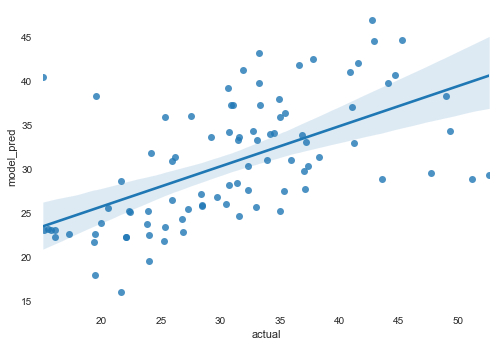

In [46]:
sns.regplot(data=results_df,x='actual',y='model_pred')
plt.show()

In [47]:
train_pred = model.predict(X_train)
train_score = r2_score(y_train, train_pred)
train_mse = mean_squared_error(y_train, train_pred)
print(f'Test data R-2 score: {train_score}')
print(f'Test data RMSE score: {np.sqrt(train_mse)}')

Test data R-2 score: 0.42278071282015717
Test data RMSE score: 7.618621890759677


In [48]:
test_score = r2_score(y_test, test_pred)
mse = mean_squared_error(y_test, test_pred)
print(f'Test data R-2 score: {test_score}')
print(f'Test data RMSE score: {np.sqrt(mse)}')

Test data R-2 score: 0.2950123009061817
Test data RMSE score: 7.449633723135555


##### Actual RMSE(untransformed)

In [49]:
mse = mean_squared_error(y_test, test_pred)
print(f'Test data actual RMSE(inverse transform applied) score: {inv_boxcox(np.sqrt(mse),lpc_lambda)}')

Test data actual RMSE(inverse transform applied) score: 28.28128657062913


#### 8. Conclusion

The SVR model looks to give the best predictions. The looks to be a big difference between the train and test r2 however the 
rmse are quite close. This will suggest that there is a low chance of overfitting. 

#### 9. To improve / productionise:
    1. Try feature engineering 
    2. Try changing parameters used in preprocessing(outlier cutoff, feature scaling) and modelling parameters
    3. Use pipelines 
    4. Unit testing
    5. Integration testing